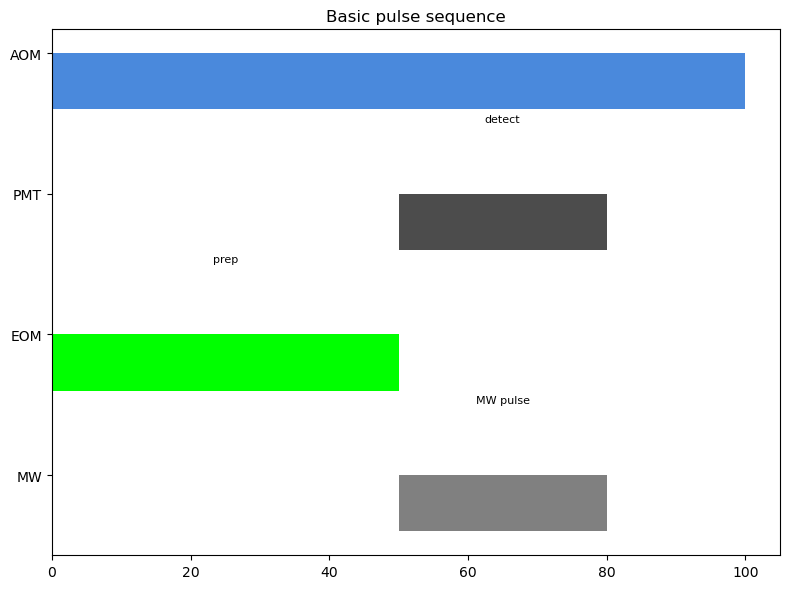

In [1]:
# ===== examples/basic.py =====
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from week4.core import Sequence, Pulse
from week4.plot import plot_matplotlib

# build a simple sequence
t = 0
prep = 50
det  = 30
dop  = 20

seq = Sequence()
seq.add(Pulse('EOM',    0,    prep, 'lime', label='prep'))
seq.add(Pulse('PMT',    prep, det,  '#4C4C4C', label='detect'))
seq.add(Pulse('AOM',    0,    prep+det+dop, '#4A89DC'))
seq.add(Pulse('MW',     prep, det,  'grey', label='MW pulse'))

fig, ax = plot_matplotlib(seq)
ax.set_title('Basic pulse sequence')
fig.tight_layout()

C:\Users\iks14535\AppData\Local\Temp\ipykernel_31312\3189196959.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


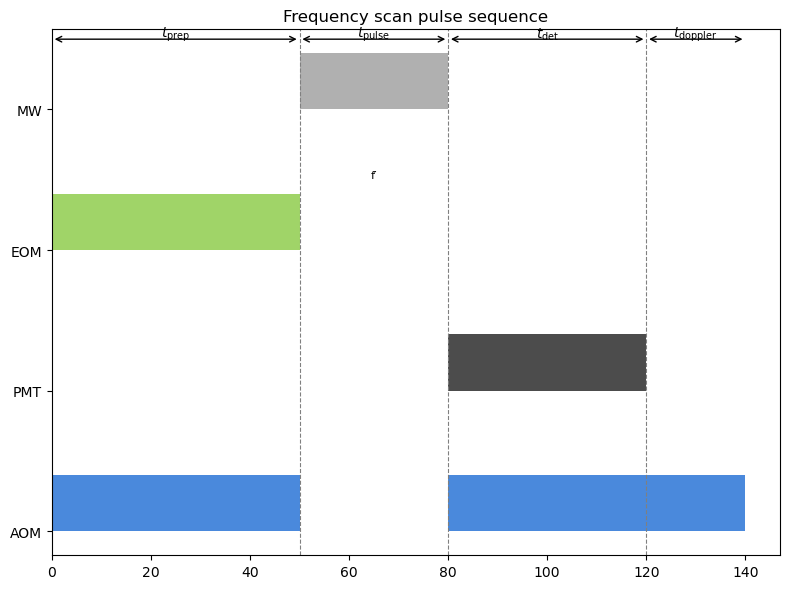

In [2]:
from week4.core import Sequence, Pulse
from week4.plot import plot_matplotlib

# 1) define your stage durations
t_prep    = 50
t_pulse   = 30
t_det     = 40
t_doppler = 20

# 2) build the sequence
seq = Sequence()
# EOM on during prep
seq.add(Pulse('EOM', 0,          t_prep,    '#A0D468'))
# AOM on during prep
seq.add(Pulse('AOM', 0,          t_prep,    '#4A89DC'))
# MW pulse during t_pulse (labelled f′)
seq.add(Pulse('MW',  t_prep,     t_pulse,   '#B0B0B0', label="f′"))
# PMT on during detection
seq.add(Pulse('PMT', t_prep+t_pulse, t_det,  '#4C4C4C'))
# AOM on during det + doppler
seq.add(Pulse('AOM', t_prep+t_pulse, t_det+t_doppler, '#4A89DC'))

# 3) choose the vertical order you want
channel_order = ['MW','EOM','PMT','AOM']

# 4) plot it
fig, ax = plot_matplotlib(seq, channel_order=channel_order)
ax.set_title("Frequency scan pulse sequence")

# 5) flip y so MW is at the top
ax.invert_yaxis()

# 6) draw the dashed separators at each boundary
for t in (t_prep,
          t_prep + t_pulse,
          t_prep + t_pulse + t_det):
    ax.axvline(t, color='grey', linestyle='--', linewidth=0.8)

# 7) annotate the four intervals with double-headed arrows
intervals = [t_prep, t_pulse, t_det, t_doppler]
starts    = [0, t_prep, t_prep+t_pulse, t_prep+t_pulse+t_det]
labels    = [r'$t_{\mathrm{prep}}$',
             r'$t_{\mathrm{pulse}}$',
             r'$t_{\mathrm{det}}$',
             r'$t_{\mathrm{doppler}}$']
y_arrow = -0.5  # a little below your lowest channel

for start, dt, lab in zip(starts, intervals, labels):
    ax.annotate(
        '',
        xy=(start,        y_arrow),
        xytext=(start+dt,  y_arrow),
        arrowprops=dict(arrowstyle='<->', lw=1)
    )
    ax.text(
        start + dt/2, y_arrow - 0.1, lab,
        ha='center', va='top'
    )

fig.tight_layout()
fig.show()


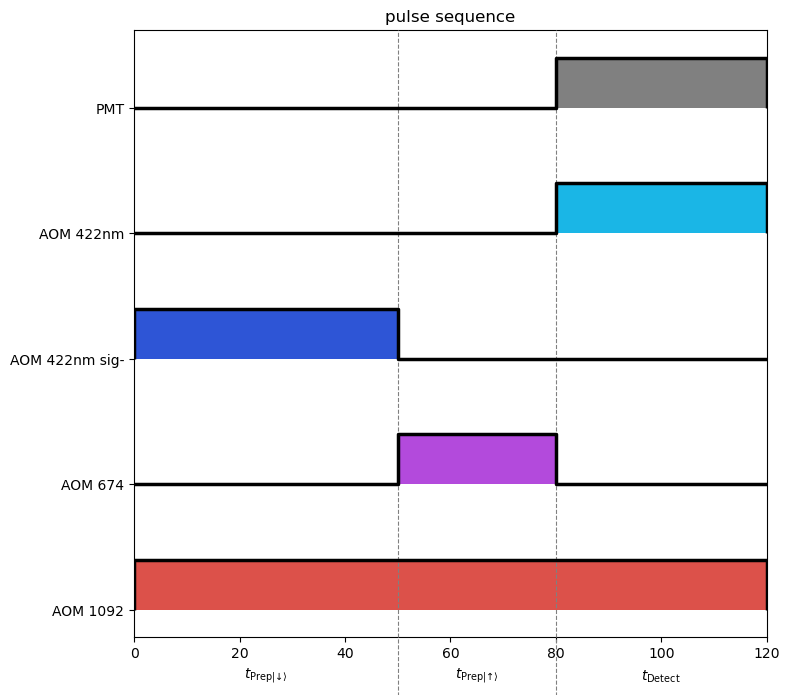

In [4]:
import matplotlib.pyplot as plt


# 1) Durations
t_prep, t_pulse, t_det= 50, 30, 40
boundaries = [
    0,
    t_prep,
    t_prep + t_pulse,
    t_prep + t_pulse + t_det
]
labels = [
    r'$t_{\mathrm{Prep |↓⟩}}$',
    r'$t_{\mathrm{Prep |↑⟩}}$',
    r'$t_{\mathrm{Detect}}$'
]

# 2) Build sequence
seq = Sequence([
    Pulse('PMT', t_prep + t_pulse ,              t_det,            'grey'),
    Pulse('AOM 422nm', t_prep + t_pulse ,              t_det,           "#1AB6E6"),
    Pulse('AOM 422nm sig-', 0, t_prep,             "#2E55D6"),
    Pulse('AOM 674',  t_prep,t_pulse           , "#B34ADC"),
    Pulse('AOM 1092', 0, t_prep + t_pulse + t_det, "#DC514A"),
])

# 3) Plot static bars
channel_order = ['PMT','AOM 422nm', 'AOM 422nm sig-', 'AOM 674', 'AOM 1092']
fig, ax = plot_matplotlib(seq, channel_order=channel_order)
ax.invert_yaxis()
ax.set_xlim(0, boundaries[-1])
ax.set_title('pulse sequence')

# 4) Remove rectangle borders & send bars behind
for p in ax.patches:
    p.set_edgecolor('none')
    p.set_zorder(1)

# 5) Draw “bumpy” baselines at bar bottoms/tops
bar_height = 0.4
y0_off = 0  # offset relative to channel index
y1_on  = -bar_height

for idx, ch in enumerate(channel_order):
    intervals = [(p.t0, p.t0 + p.dt)
                 for p in seq.by_channel().get(ch, [])]
    xs, ys = [], []
    t_cursor = 0

    for start, end in intervals:
        # OFF: horizontal at bottom
        xs += [t_cursor, start]
        ys += [idx + y0_off, idx + y0_off]
        # RISE
        xs += [start, start]
        ys += [idx + y0_off, idx + y1_on]
        # ON
        xs += [start, end]
        ys += [idx + y1_on, idx + y1_on]
        # FALL
        xs += [end, end]
        ys += [idx + y1_on, idx + y0_off]
        t_cursor = end

    # final OFF back to end
    xs += [t_cursor, boundaries[-1]]
    ys += [idx + y0_off, idx + y0_off]

    ax.plot(
    xs, ys,
    color='black',
    linewidth=2.5,
    solid_capstyle='butt',  # ← exactly butt‐capped so no overshoot
    zorder=5
)

# 6) Separator lines and arrows
# To extend the separator lines below the x-axis, use ax.transAxes for ymin/ymax in axes coordinates.
for t in boundaries[1:-1]:
    ax.axvline(
        t,
        linestyle='--',
        color='grey',
        linewidth=0.8,
        zorder=4,
        ymin=-0.12,  # full axis range in data coordinates
        ymax=1.0,
        clip_on=False  # allow line to extend outside the axes
    )
    # Draw an extra line in axes coordinates to extend below x-axis
    ax.plot([t, t], [-0.3, 0], color='grey', linestyle='--', linewidth=0.8, zorder=4, transform=ax.get_xaxis_transform())

y_top = len(channel_order) - 0.5
for start, end, text in zip(boundaries, boundaries[1:], labels):
    ax.annotate('', xy=(start, y_top), xytext=(end, y_top),
                arrowprops=dict(arrowstyle='<->', lw=1), zorder=6)
    ax.text((start+end)/2, y_top+0.1, text,
            ha='center', va='bottom', zorder=6)

fig.tight_layout()
plt.show()
